## Lib

In [1]:
# !pip install spacy
# !pip install transformers datasets
# !pip install scikit-learn
# !pip install numpy requests nlpaug sentencepiece
# !pip install protobuf
# !pip install accelerate
# !pip install sentence-transformers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import LlamaForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util

import nlpaug.augmenter.word as naw

import time
from tqdm import tqdm
import random

In [2]:
SEED = 42
random.seed(SEED)           # Python random
np.random.seed(SEED)        # NumPy random
torch.manual_seed(SEED)     # PyTorch CPU
torch.cuda.manual_seed_all(SEED)  # PyTorch GPU (if used)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load & Clean Dataset

In [55]:
def create_df(data_file):
    with open(data_file, 'r') as file:
        text_list = []
        label_list = []
        for line in file:
            result = line.strip().split(':')
            label_list.append(result[0])
            text_list_ = result[1].split()
            text_list.append(' '.join(text_list_[1:]))

    data = {
        "text": text_list,
        "label": label_list
    }

    return pd.DataFrame(data)

train_path = 'C:/Users/yauju/Documents/DS notebook/nlp_project/data/train_5500.txt'
train_df = create_df(train_path)
test_df = create_df(r'C:/Users/yauju/Documents/DS notebook/nlp_project/data/TREC_10.txt')
        

In [35]:
train_df

,text,label
0,How did serfdom develop in and then leave Russ...,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real na...,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY
4,What is the full form of .com ?,ABBR
...,...,...
5447,What 's the shape of a camel 's spine ?,ENTY
5448,What type of currency is used in China ?,ENTY
5449,What is the temperature today ?,NUM
5450,What is the temperature for cooking ?,NUM


In [5]:
train_df['label'].value_counts()

label
ENTY    1250
HUM     1223
DESC    1162
NUM      896
LOC      835
ABBR      86
Name: count, dtype: int64

In [27]:
train_df.duplicated().sum()

np.int64(75)

In [56]:
train_df.drop_duplicates(inplace=True)

In [6]:
possible_labels = train_df.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

index_to_label = {v: k for k, v in label_dict.items()}

label_dict

{'DESC': 0, 'ENTY': 1, 'ABBR': 2, 'HUM': 3, 'NUM': 4, 'LOC': 5}

In [57]:
train_df['label'] = train_df.label.replace(label_dict)
test_df['label'] = test_df.label.replace(label_dict)

C:\Users\yauju\AppData\Local\Temp\ipykernel_21192\3578331454.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'] = train_df.label.replace(label_dict)
C:\Users\yauju\AppData\Local\Temp\ipykernel_21192\3578331454.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label'] = test_df.label.replace(label_dict)


In [58]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=42)
X_test, y_test = test_df['text'], test_df['label']

## Traditional Augment

In [38]:
aug_list = [
    naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert", aug_p=0.1),
    naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", aug_p=0.1)
]

def augment_text(X_train, y_train, p_aug=0.3):
    new_text=[]
    new_label = []
    counter = 0
    ## data augmentation loop   
    for text, label in tqdm(zip(X_train, y_train), total=len(X_train)):
        augmented = False
        for aug in aug_list:
            if random.random() < p_aug:
                text = aug.augment(text)
                augmented = True
                
        if  augmented:
            counter += 1
            if isinstance(text, list):
                text = text[0]
            new_text.append(text)
            new_label.append(label)

    ## dataframe
    X_train.extend(new_text)
    y_train.extend(new_label)
    
    df=pd.DataFrame({'text':X_train, 'label':y_train}).sample(frac=1).reset_index(drop=True)

    return df['text'], df['label'], counter
    
X_train, y_train, augmented_count = augment_text(X_train.tolist(),y_train.tolist(), 0.3)

100%|██████████████████████████████████████████████████████████████████████████████| 4301/4301 [02:56<00:00, 24.33it/s]


In [63]:
# traditional augmented text sample
aug_df = df.sample(10)
for idx, row in aug_df.iterrows():
    print(row['text'])

("What magazine paid $5 , 000 for an eight-millimeter film of John F. Kennedy 's assassination ?", "what magazine paid $ 8 5, 000 for an eight - millimeter film of john paul f. year kennedy ' s assassination?")
('What is a handheld PC ?', 'so what is a handheld machine?')
('The Kentucky Horse Park is close to which American city ?', 'the kentucky national park is close at which american city?')
('How can I gain access to a spy satelite ?', 'how can i gain access to each single satelite?')
('What is the definition of a cascade ?', 'what is the definition now of a cascade?')
('What square is the geographical center of London ?', 'what square is the geographical centre of london?')
("What is the biblical meaning of ` stones ' ?", "what is the biblical meaning of ` these stones '?")
('How many engines does a Boeing 737 have ?', 'how many engines does even a boeing 737 have?')
("What 's the American dollar equivalent for 8 pounds in the U.K. ?", "what ' s his american male equivalent being 

In [39]:
print("augmented data: ", augmented_count)

augmented data:  2168


## LLM Augmenting

In [ ]:
# access_token = EMPTY

# 1. Load the model and tokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
llm_tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=access_token)
llm_model = LlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto", use_auth_token=access_token)

embedder = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")

C:\Users\yauju\miniconda3\envs\nlp_env\Lib\site-packages\transformers\models\auto\tokenization_auto.py:1025: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
C:\Users\yauju\miniconda3\envs\nlp_env\Lib\site-packages\transformers\modeling_utils.py:4718: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [10]:
def is_good_paraphrase(original, candidate, min_sim=0.65, max_sim=0.98):
    emb = embedder.encode([original, candidate])
    sim = util.cos_sim(emb[0], emb[1]).item()
    return min_sim <= sim <= max_sim, sim
    
def generate_augment_llm(X_train, y_train, label_class):
    y_train_sub = y_train[y_train.isin(label_class)]
    X_train_sub = X_train.loc[y_train_sub.index]

    augmented_text_dict = {}
    augmented_label_dict = {}
    
    for text, label in tqdm(zip(X_train_sub, y_train_sub), total=len(y_train_sub)):
        augmented = []
        prompt =  f"Rephrase the question below without changing its meaning. Do NOT answer it.\n\nSentence: {text}\nRephrased:"
        inputs = llm_tokenizer(prompt, return_tensors="pt").to(llm_model.device)
        for _ in range(5):
            output = llm_model.generate(
                **inputs,
                max_new_tokens=50,
                temperature=0.8,   # adds variation
                top_p=0.9,
                do_sample=True,    # enables sampling (vs greedy)
                pad_token_id=llm_tokenizer.eos_token_id,
                eos_token_id=llm_tokenizer.eos_token_id
            )
            decoded = llm_tokenizer.decode(output[0], skip_special_tokens=True)
            try:
                rephrased = decoded.split("Rephrased:")[-1].split("\n")[0].strip()
                augmented.append(rephrased)
                
            except IndexError:
                # Skip this one if the expected pattern isn't found
                continue
        if augmented:  # only if at least one succeeded
            augmented_text_dict[text] = augmented
            augmented_label_dict[text] = label     
        
    return augmented_text_dict, augmented_label_dict

In [11]:
augmented_text_dict, augmented_label_dict = generate_augment_llm(X_train,y_train, [2])

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [04:39<00:00,  3.88s/it]


In [12]:
def filter_paraphrase(augmented_text_dict, top_k = 2):
    filtered_augmented = {}
    for key, values in augmented_text_dict.items():
        aug_list = []
        for value in values:
            sim_bool, sim = is_good_paraphrase(key, value)
            if sim_bool:
                aug_list.append((value,sim))
        sorted_augs = sorted(aug_list, key=lambda x: x[1], reverse=True)
        if sorted_augs:
            sorted_augs_sub = sorted_augs[:top_k]
            filtered_augmented[key] = sorted_augs_sub
        #     print(f"original_sentence: {key}, augmented sentence with highest score: {sorted_augs_sub[0][0]}, sim score = {sorted_augs_sub[0][1]:.4f}")
        #     print(f"original_sentence: {key}, augmented sentence with lowest score: {sorted_augs_sub[-1][0]}, sim score = {sorted_augs_sub[-1][1]:.4f}")
        # else:
        #     print(f"original_sentence: {key}, no paraphrases passed the similarity threshold.")

    return filtered_augmented
augmented_text_dict_filtered = filter_paraphrase(augmented_text_dict)

In [32]:
print(augmented_text_dict_filtered)

{'What is HDLC ?': [('What is HDLC protocol?', 0.8819389343261719)], "What 's the abbreviation for limited partnership ?": [('What is the acronym for limited partnership?', 0.9648383855819702)], 'What does CNN stand for ?': [('What does CNN stand for in English?', 0.9286143779754639), ('What is the acronym for CNN?', 0.8410291075706482)], 'What does BMW stand for ?': [('What is the origin of BMW?', 0.8544079065322876), ('What is the origin or meaning of the name BMW?', 0.8412203192710876)], 'What does Ms. , Miss , and Mrs. stand for ?': [('What do the titles of Ms., Miss, and Mrs. represent?', 0.8738323450088501), ('What is the meaning of the initials Ms., Miss, and Mrs.?', 0.8565558195114136)], 'What does LOL mean ?': [('What is the meaning of the word LOL?', 0.8808706402778625), ('What is the meaning of the word LOL?', 0.8808706402778625)], 'What is DEET ?': [('What is DEET used for?', 0.9221736788749695), ('What is the chemical compound commonly known as DEET?', 0.75974440574646)], 

In [29]:
# dict len (2 data doesnt have meaningful paraphrase)
print(len(augmented_text_dict_filtered))

# augmented count
total_length = sum(len(v) for v in augmented_text_dict_filtered.values())
print(total_length)

70
134


In [33]:
# original unaugmented data count
206-134

72

In [13]:
def extend_train_df(X_train, y_train, augmented_text_dict_filtered, augmented_label_dict):
    for key, values in augmented_text_dict_filtered.items():
        for value in values:
            X_train.append(value[0])
            y_train.append(augmented_label_dict[key])
    
    df=pd.DataFrame({'text':X_train, 'label':y_train}).sample(frac=1).reset_index(drop=True)
    return df['text'], df['label']
X_train, y_train = extend_train_df(X_train.tolist(), y_train.tolist(), augmented_text_dict_filtered, augmented_label_dict)

In [14]:
y_train_sub = y_train[y_train.isin([2])]
X_train_sub = X_train.loc[y_train_sub.index]

In [15]:
X_train_sub

4             What does Ms. , Miss , and Mrs. stand for ?
14                                 What is DEET used for?
30                                          What is SIDS?
31                    What is the origin of the term RCA?
62       What is the definition of the abbreviation AIDS?
                              ...                        
4301      What does INRI mean when Jesus is on the cross?
4317    What does "OE" stand for in the context of Ori...
4318      What is the meaning of E in the equation E=mc2?
4319                    What does the abbreviation cwt. ?
4430            What is the purpose of RAM in a computer?
Name: text, Length: 206, dtype: object

## Model init & Training

In [17]:
class TRECDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [40]:
MAX_LEN = 50
BATCH_SIZE = 32

train_dataset = TRECDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = TRECDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = TRECDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [41]:
# BertConfig, increase dropout prob
config = BertConfig.from_pretrained('bert-base-uncased',
                                    num_labels=6,
                                    hidden_dropout_prob=0.3,
                                    attention_probs_dropout_prob=0.3)


# # Create model with modified config
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

model = model.to(device)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

The following layers were not sharded: bert.encoder.layer.*.attention.self.query.bias, bert.pooler.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.key.bias, classifier.bias, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.token_type_embeddings.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.attention.output.LayerNorm.bias, classifier.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.pooler.dense.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.output.dense.weight, b

In [20]:
def train_epoch(model, data_loader, val_loader, optimizer, device, step_count=0):
    train_acc_list = []
    model.train()
    running_loss = 0
    correct_predictions = 0
    total_samples_seen = 0
    
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        running_loss += loss.item()
        total_samples_seen += labels.size(0)
        if step_count%10 == 0 and step_count != 0:
            avg_loss = running_loss / 10
            training_losses.append(avg_loss)
            running_loss = 0.0
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        step_count += 1
        
        if step_count%100 == 0:
            train_acc = correct_predictions.double() / total_samples_seen
            train_acc_list.append(train_acc)
            correct_predictions = 0
            val_acc = evaluate_model(model, val_loader, device)
            val_accuracies.append(val_acc)
            total_samples_seen = 0
            model.train()
    
    return train_acc_list, step_count


# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset)

### No augment

In [ ]:
# no augment
training_losses = []
train_accuracies = []
val_accuracies = []

EPOCHS = 5
step_count = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    train_acc, step_count = train_epoch(model, train_loader, val_loader, optimizer, device, step_count)
    train_accuracies.extend(train_acc)
    print(f'time taken: {time.time()-start_time}')

### Traditional Augment

In [42]:
# traditional augment
training_losses = []
train_accuracies = []
val_accuracies = []

EPOCHS = 5
step_count = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    train_acc, step_count = train_epoch(model, train_loader, val_loader, optimizer, device, step_count)
    train_accuracies.extend(train_acc)
    print(f'time taken: {time.time()-start_time}')

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [01:41<00:00,  2.00it/s]


time taken: 101.37654519081116
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [01:45<00:00,  1.93it/s]


time taken: 105.23046875
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [01:47<00:00,  1.88it/s]


time taken: 107.85578989982605
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [01:48<00:00,  1.87it/s]


time taken: 108.34202837944031
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [01:49<00:00,  1.86it/s]

time taken: 109.30726861953735


### LLM Augment

In [21]:
# llm augment
training_losses = []
train_accuracies = []
val_accuracies = []

EPOCHS = 5
step_count = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    train_acc, step_count = train_epoch(model, train_loader, val_loader, optimizer, device, step_count)
    train_accuracies.extend(train_acc)
    print(f'time taken: {time.time()-start_time}')

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [01:11<00:00,  1.95it/s]


time taken: 71.12518262863159
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [01:12<00:00,  1.93it/s]


time taken: 72.08024144172668
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [01:18<00:00,  1.77it/s]


time taken: 78.71902990341187
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [01:13<00:00,  1.90it/s]


time taken: 73.12777066230774
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [01:13<00:00,  1.88it/s]

time taken: 73.86891579627991


## Analysis

In [22]:
def print_fig():
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    train_accs_list = []
    for tensor in train_accuracies:
        train_accs_list.append(tensor.cpu().numpy().item())
        
    val_accs_list = []
    for tensor in val_accuracies:
        val_accs_list.append(tensor.cpu().numpy().item())
        
    ax[0].plot(range(len(training_losses)) , training_losses , 'go-' , label = 'Training Loss')
    ax[0].set_title('Training Loss')
    ax[0].legend()
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Loss")
    
    ax[1].plot(range(len(train_accs_list)) , train_accs_list , 'go-' , label = 'Training Accuracy')
    ax[1].plot(range(len(val_accs_list)) , val_accs_list , 'ro-' , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    
    plt.show()
    print("train accs: ",train_accs_list)
    print("val accs: ",val_accs_list)

In [23]:
def predict_test_set():
    # Evaluate the model on test set
    correct_predictions = 0
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
    
            correct_predictions += torch.sum(preds == labels)
    
    print("test accuracies = ", (correct_predictions.double() / len(test_loader.dataset)).cpu().numpy().item())
    return 

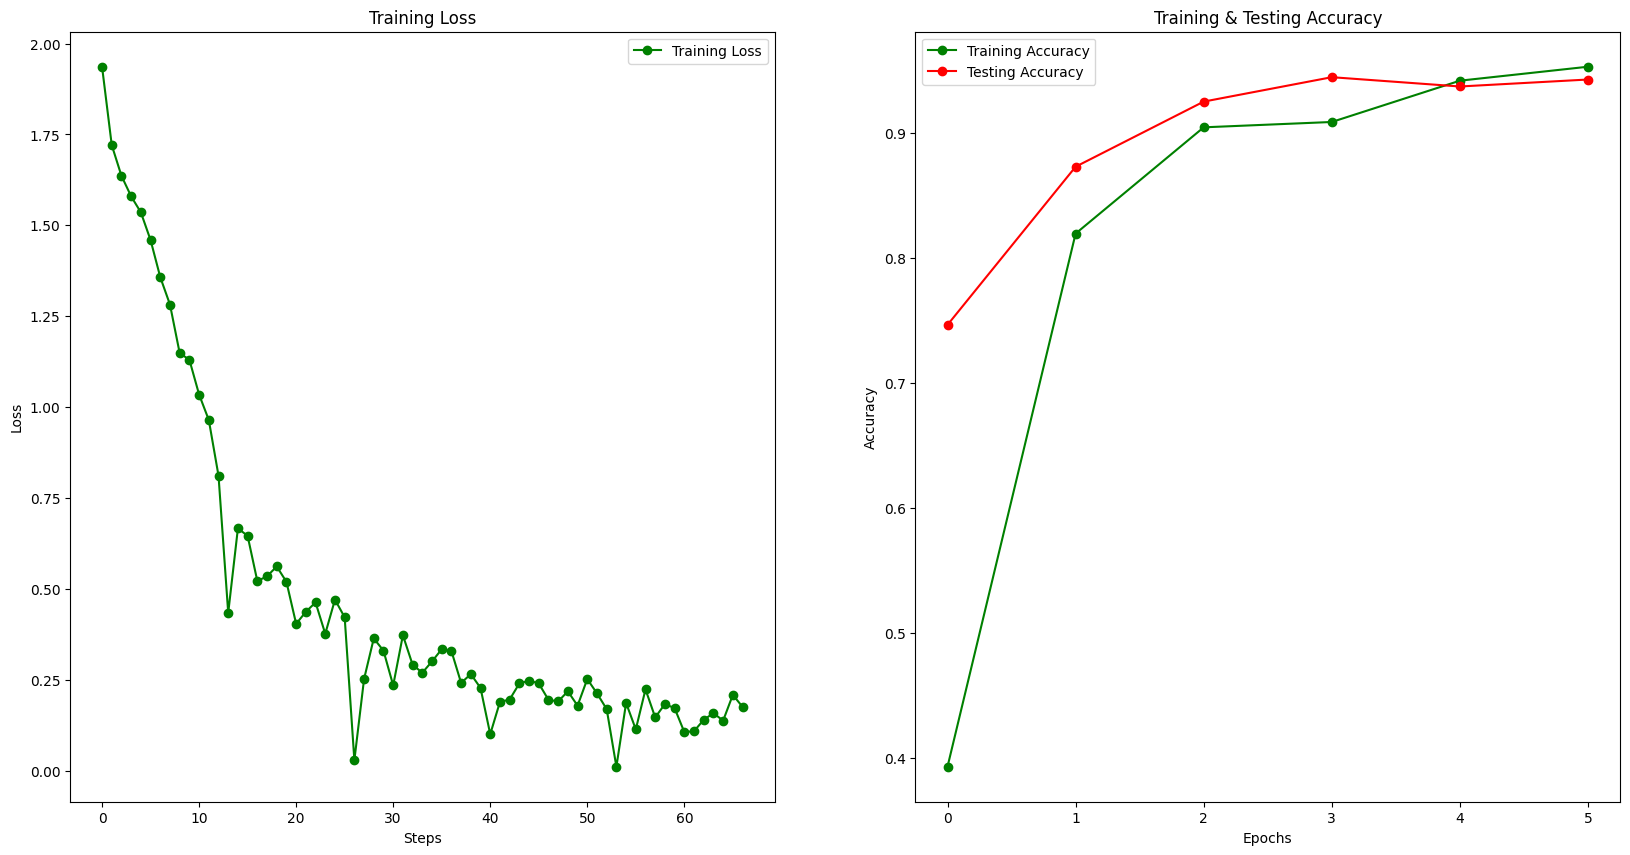

train accs:  [0.393125, 0.8192307692307693, 0.9041666666666667, 0.9084375, 0.9414473684210526, 0.9526041666666667]
val accs:  [0.7462825278810409, 0.8726765799256505, 0.9247211895910781, 0.9442379182156133, 0.9368029739776951, 0.9423791821561338]


In [16]:
# bert 5 epoch dropout
print_fig()

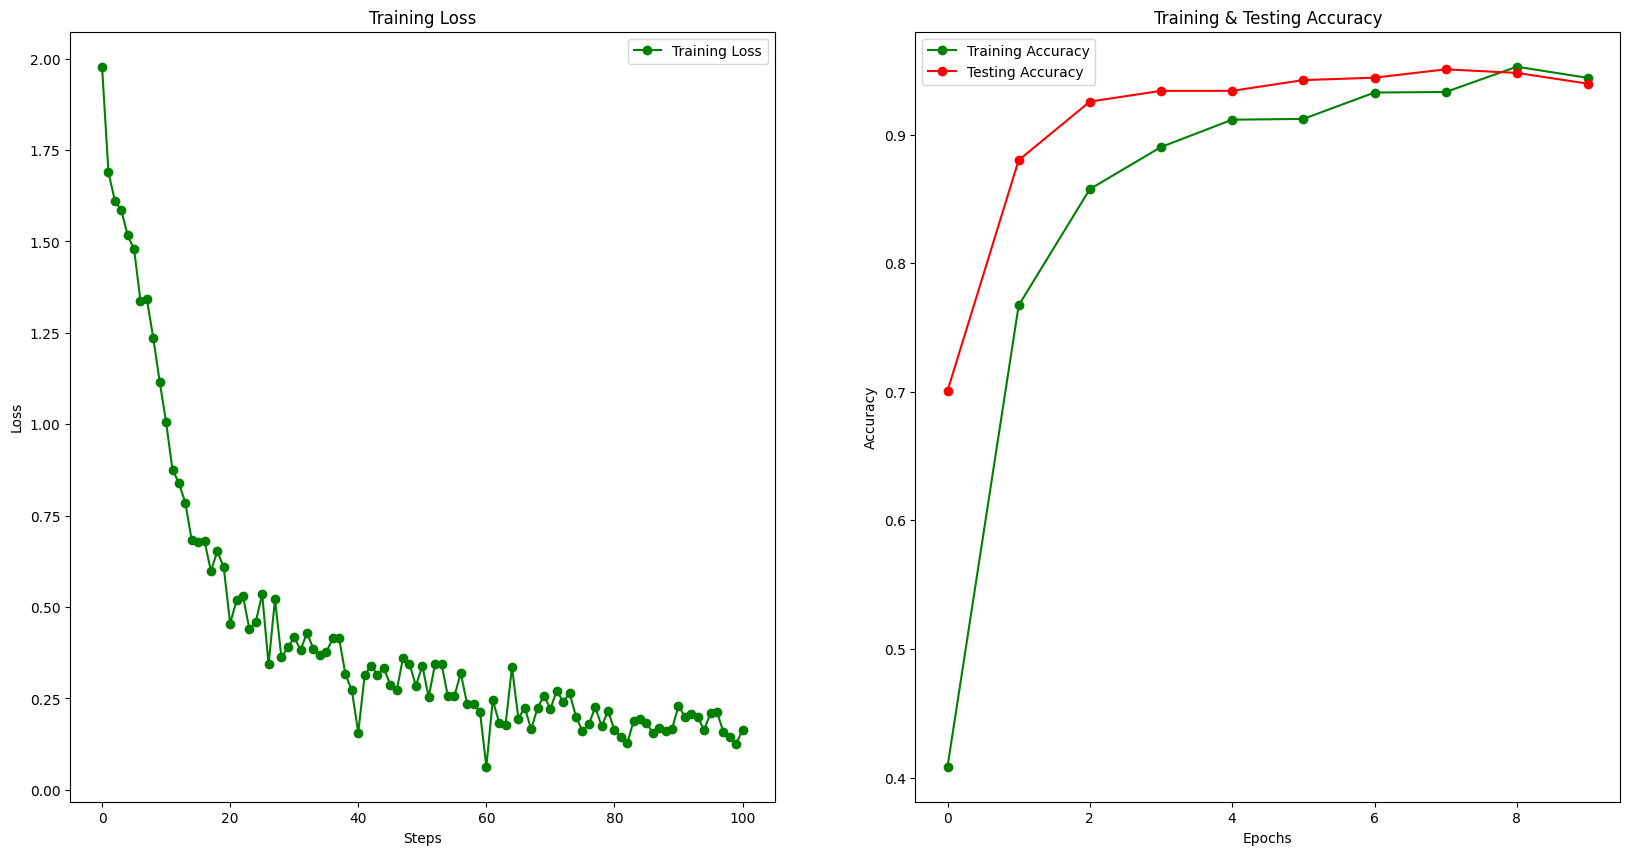

train accs:  [0.4084375, 0.7671875, 0.8576030927835051, 0.8903125000000001, 0.9115691489361701, 0.9121875, 0.9326923076923078, 0.933125, 0.9527698863636364, 0.9440625]
val accs:  [0.7007434944237918, 0.8801115241635687, 0.9256505576208178, 0.9340148698884758, 0.9340148698884758, 0.9423791821561338, 0.9442379182156133, 0.9507434944237918, 0.9479553903345724, 0.9395910780669144]


In [43]:
# bert 5 epoch dropout traditional augment
print_fig()

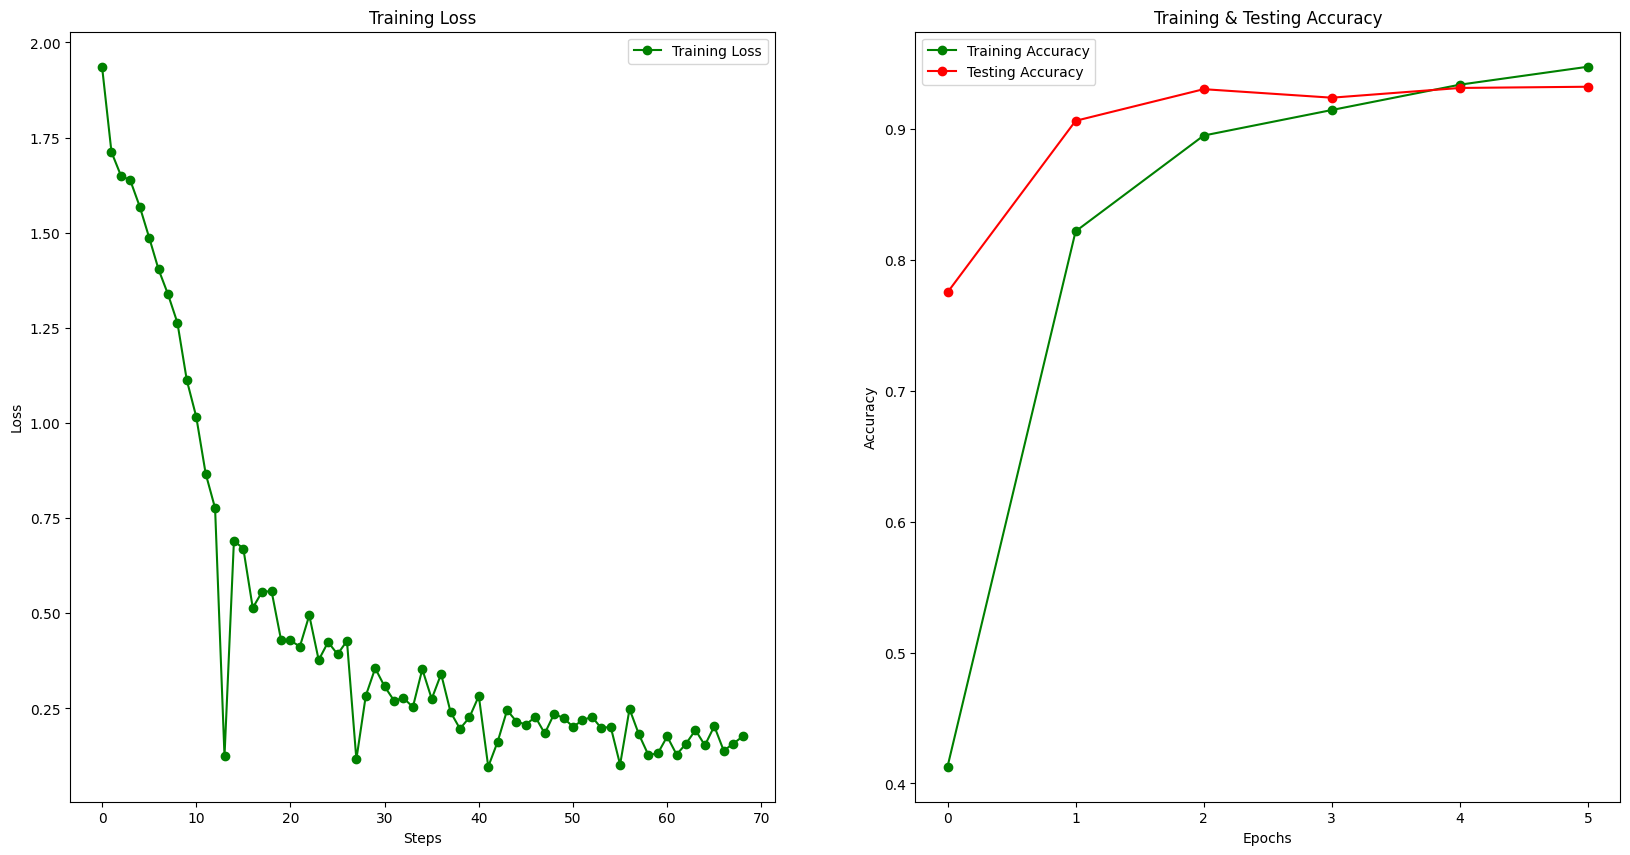

train accs:  [0.4128125, 0.8217213114754098, 0.8948863636363636, 0.914375, 0.9337349397590362, 0.9474431818181819]
val accs:  [0.775092936802974, 0.9061338289962825, 0.9302973977695167, 0.9237918215613382, 0.9312267657992565, 0.9321561338289962]


In [24]:
# bert 5 epoch dropout llm augment
print_fig()

In [17]:
# bert 5 epoch dropout 
# no augment
predict_test_set()

test accuracies =  0.974


In [44]:
# bert 5 epoch dropout
# traditional augment
predict_test_set()

test accuracies =  0.962


In [25]:
# bert 5 epoch dropout
# llm augment
predict_test_set()

test accuracies =  0.98


In [27]:
model.save_pretrained("./saved_model/model_bert/")

In [19]:
# model = BertForSequenceClassification.from_pretrained('./saved_model/model_bert')

## 3.4

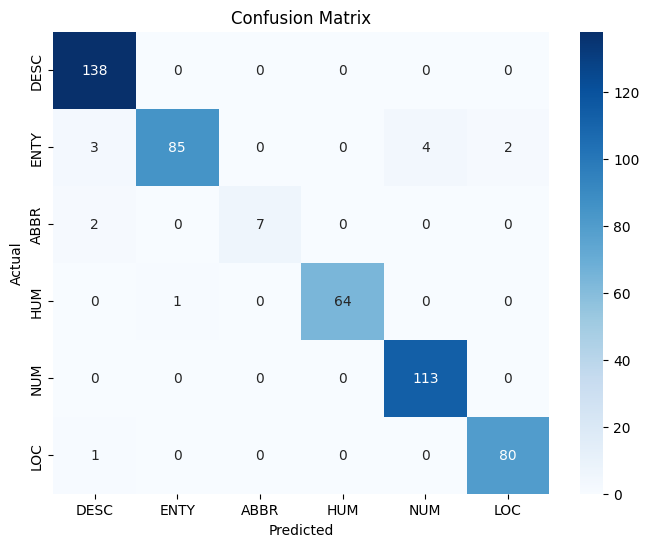

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       138
           1       0.99      0.90      0.94        94
           2       1.00      0.78      0.88         9
           3       1.00      0.98      0.99        65
           4       0.97      1.00      0.98       113
           5       0.98      0.99      0.98        81

    accuracy                           0.97       500
   macro avg       0.98      0.94      0.96       500
weighted avg       0.97      0.97      0.97       500



In [24]:
# before augment
model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

labels_sorted = [index_to_label[i] for i in sorted(index_to_label.keys())]

# Optional: plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels_sorted,
            yticklabels=labels_sorted)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(all_labels, all_preds))

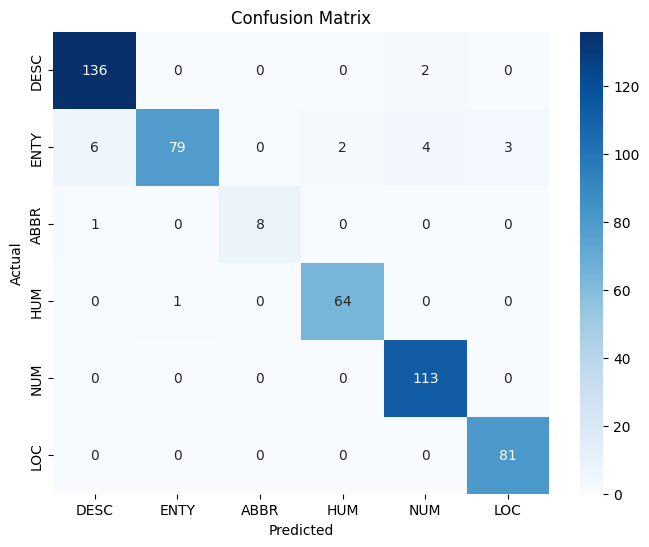

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       138
           1       0.99      0.84      0.91        94
           2       1.00      0.89      0.94         9
           3       0.97      0.98      0.98        65
           4       0.95      1.00      0.97       113
           5       0.96      1.00      0.98        81

    accuracy                           0.96       500
   macro avg       0.97      0.95      0.96       500
weighted avg       0.96      0.96      0.96       500



In [45]:
# traditional augment
model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

labels_sorted = [index_to_label[i] for i in sorted(index_to_label.keys())]

# Optional: plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels_sorted,
            yticklabels=labels_sorted)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(all_labels, all_preds))

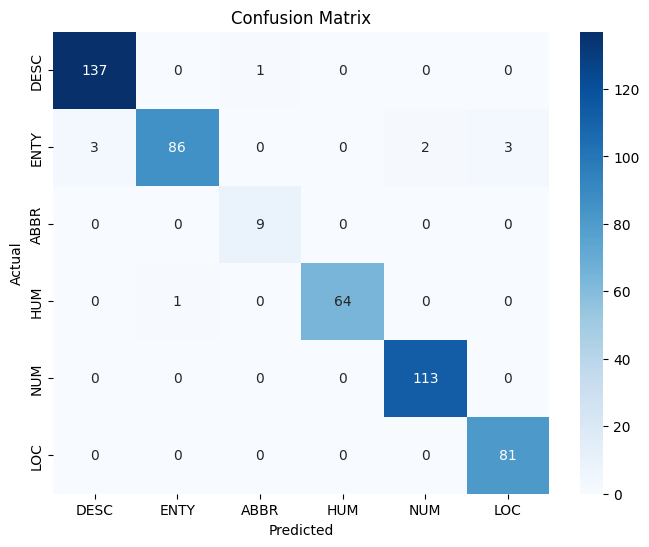

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       138
           1       0.99      0.91      0.95        94
           2       0.90      1.00      0.95         9
           3       1.00      0.98      0.99        65
           4       0.98      1.00      0.99       113
           5       0.96      1.00      0.98        81

    accuracy                           0.98       500
   macro avg       0.97      0.98      0.97       500
weighted avg       0.98      0.98      0.98       500



In [26]:
# after llm augment
model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

labels_sorted = [index_to_label[i] for i in sorted(index_to_label.keys())]

# Optional: plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels_sorted,
            yticklabels=labels_sorted)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(all_labels, all_preds))